### 1. Preparing the Data

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

N_ROWS = 28
N_COLS = 28
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

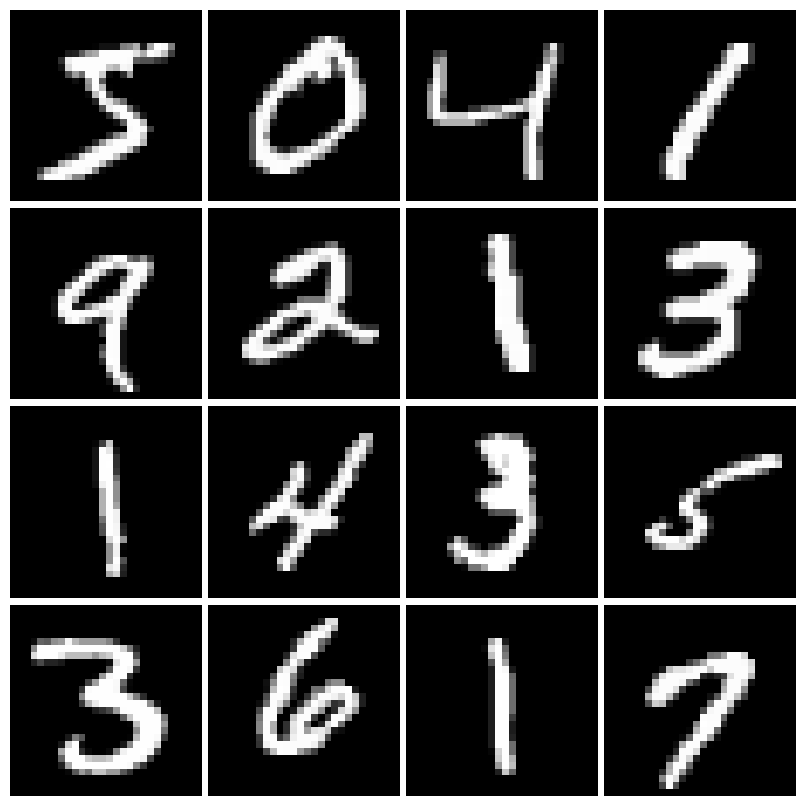

In [2]:
digits = np.reshape(x_train[:16], (16, N_ROWS, N_COLS))
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize as needed

# Iterate through the arrays and plot them in the subplots
for i, ax in enumerate(axes.flat):
    if i < len(digits): # Check if there is an image to plot in this subplot. Important for lists of arrays with size not multiple of 16
      ax.imshow(digits[i], cmap='gray')  # Assuming grayscale images; use appropriate cmap if needed
      ax.axis('off')  # Hide axes
    else:
      ax.axis('off') # Hide axes even if there's no image in this subplot
      ax.set_xticklabels([]) # Remove labels to avoid errors
      ax.set_yticklabels([]) # Remove labels to avoid errors

plt.tight_layout(pad=0.5) # Adjust spacing between subplots
plt.show()

In [3]:
# Flatten the images and normalize
flat_shape = np.prod(x_train.shape[1:])
x_train = x_train.reshape(-1, flat_shape).astype("float32") / 255.0
x_test = x_test.reshape(-1, flat_shape).astype("float32") / 255.0

### 2. Writing TFRecords

In [4]:
import os

def serialize_example(feature, label):
    """Converts raw data into tf.train.Example."""
    feature = {
        "image": tf.train.Feature(float_list=tf.train.FloatList(value=feature)),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_multiple_tfrecords(prefix, features, labels, examples_per_file=20000):
    """
    Write multiple TFRecord files.

    Parameters:
    - prefix (str): Prefix for the TFRecord file names (e.g., "train" or "test").
    - features (np.array): Array of feature data.
    - labels (np.array): Array of label data.
    - examples_per_file (int): Number of examples to write per TFRecord file.
    """
    num_examples = len(features)
    num_files = (num_examples + examples_per_file - 1) // examples_per_file  # Calculate number of files needed

    for file_idx in range(num_files):
        # File path for each TFRecord file
        filename = f"{prefix}_{str(file_idx + 1).zfill(3)}.tfrecord"
        start_idx = file_idx * examples_per_file
        end_idx = min(start_idx + examples_per_file, num_examples)

        with tf.io.TFRecordWriter(filename) as writer:
            for i in range(start_idx, end_idx):
                example = serialize_example(features[i], labels[i])
                writer.write(example)

        print(f"Saved {filename} with {end_idx - start_idx} examples.")

# Save train and test data to multiple TFRecord files
write_multiple_tfrecords("train", x_train, y_train, examples_per_file=20000)
write_multiple_tfrecords("test", x_test, y_test, examples_per_file=4000)

Saved train_001.tfrecord with 20000 examples.
Saved train_002.tfrecord with 20000 examples.
Saved train_003.tfrecord with 20000 examples.
Saved test_001.tfrecord with 4000 examples.
Saved test_002.tfrecord with 4000 examples.
Saved test_003.tfrecord with 2000 examples.


### 3. Creating a tf.data.Dataset for Training

In [5]:
def preprocess(features):
    # Extract image and label
    image = features["image"]
    label = features["label"]
    # Reshape the image
    image = tf.reshape(image, [N_ROWS, N_COLS])
    return image, label

# Define the feature description to parse each TFRecord
feature_description = {
    "image": tf.io.FixedLenFeature([N_ROWS * N_COLS], tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

def load_multiple_tfrecords(file_pattern, batch_size=32, shuffle_buffer=1024):
    # List all files matching the pattern (e.g., "train_*.tfrecord")
    files = tf.data.Dataset.list_files(file_pattern)

    # Create a TFRecordDataset from the list of files
    dataset = files.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Parse the records and preprocess
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # number of batches to prefetch asynchronously while training

    return dataset

# Load train and test datasets from multiple TFRecord files
train_dataset = load_multiple_tfrecords("train_*.tfrecord", batch_size=32)
test_dataset = load_multiple_tfrecords("test_*.tfrecord", batch_size=32)

### 4. Building and Training a Model

In [6]:
# Define a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(N_ROWS, N_COLS)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2559 - accuracy: 0.9276 - val_loss: 0.1426 - val_accuracy: 0.9571
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1137 - accuracy: 0.9661 - val_loss: 0.1213 - val_accuracy: 0.9602
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0777 - accuracy: 0.9766 - val_loss: 0.0862 - val_accuracy: 0.9732
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0578 - accuracy: 0.9817 - val_loss: 0.0825 - val_accuracy: 0.9740
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.0806 - val_accuracy: 0.9751


### 5. Evaluating the Model

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0806 - accuracy: 0.9751
Test Loss: 0.0806, Test Accuracy: 0.9751


### 6. Size comparison among different formats

In [8]:
import numpy as np
import pandas as pd

path_mnist = 'C:/Users/IRPEREZ/.keras/datasets/mnist.npz'
data_full = np.load(path_mnist)
data_separated: dict = {key: data_full[key] for key in data_full.files}

In [9]:
# CSV: 271 MB
# TFRecord: 212 MB
# Parquet: 47.3 MB
for key, arr in data_separated.items():
    data_partition = arr
    if len(data_partition.shape) == 3:
        data_partition = data_partition.reshape((data_partition.shape[0], data_partition.shape[1] * data_partition.shape[2]))
    else:
        data_partition = np.expand_dims(data_partition, axis=1)
    pd.DataFrame(data_partition / 256, columns=[str(i) for i in range(data_partition.shape[1])]).to_parquet(f'{key}.parquet', index=False)
    pd.DataFrame(data_partition / 256, columns=[str(i) for i in range(data_partition.shape[1])]).to_csv(f'{key}.csv', index=False)

### Conclusion
- tf.data.Dataset is a native structure in TF that can be passed directly to a training .fit()
- It is optimized to reduce the data bottleneck during training, by loading data from files in chunks to memory, and not at once.
- It uses multithreading for data loading.
- A tf.data.Dataset can be built from a set of .tfrecord files.
- The size of the .tfrecords is much smaller than text files (i.e. CSVs) although bigger than parquets.
- The dataset can be easily shuffled, batched and prefetched, improving quality training and efficiency.
- The data in any format could be converted to TFRecord before uploading it to the cloud.